# t-SNE 範例

(Optional) 若尚未安裝相關套件，執行下一行，然後 restart kernel

In [1]:
!pip3 install --user sklearn
!pip3 install --user --upgrade matplotlib

'pip3' 不是內部或外部命令、可執行的程式或批次檔。
'pip3' 不是內部或外部命令、可執行的程式或批次檔。


載入套件

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets

%matplotlib inline

載入 digits (4個數字) 資料集

In [67]:
digits = datasets.load_digits(n_class=4)
X = digits.data
y = digits.target
print(f'X.shape={X.shape}, y.shape={y.shape}')
print(digits.DESCR)

X.shape=(720, 64), y.shape=(720,)
.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of 

設定 模型 估計參數

In [68]:
n_samples, n_features = X.shape
n_neighbors = 30

'''
class sklearn.manifold.TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, 
    learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, 
    metric=’euclidean’, init=’random’, verbose=0, random_state=None, method=’barnes_hut’, angle=0.5)[source]
    
t-distributed Stochastic Neighbor Embedding

t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to 
joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of 
the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, 
i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD 
for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. 
This will suppress some noise and speed up the computation of pairwise distances between samples. 
For more tips see Laurens van der Maaten’s FAQ

n_components : int, optional (default: 2)
Dimension of the embedded space.

perplexity : float, optional (default: 30)
The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. 
Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. 
The choice is not extremely critical since t-SNE is quite insensitive to this parameter.

init : string or numpy array, optional (default: “random”)
Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). 
PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

learning_rate : float, optional (default: 200.0)
The learning rate for t-SNE is usually in the range [10.0, 1000.0]. 
If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant 
from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud 
with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.
'''

tsne_estimator = manifold.TSNE(n_components=2, perplexity=n_neighbors, random_state=0, init='pca', learning_rate=200., early_exaggeration=12.)

資料建模 並 視覺化 結果

Computing t-SNE embedding
shown_images = [[1. 1.]], X.shape[0]=720


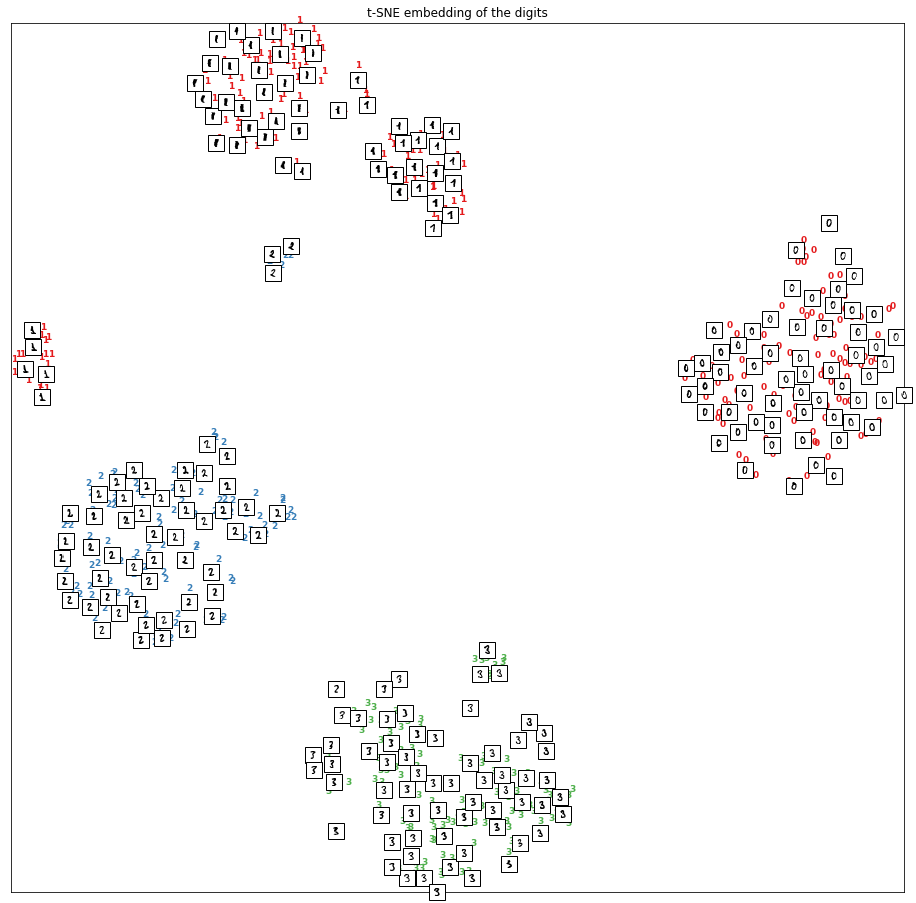

In [69]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    
    # Do normalize => 0 ~ 1.0
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(16, 16))
    ax = plt.subplot(111)
    
    '''
    Draw label(or y[i)) with color in coordinate ( X[i, 0], X[i, 1] )
    '''
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    
    '''
    Draw text thumbnails with annotation box
    '''
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        print(f'shown_images = {shown_images}, X.shape[0]={X.shape[0]}')
        for i in range(X.shape[0]):
            
            # shown_images: drawed image matrix
            # dist_matrix: a matrix contains offset (of each axis) to each of shown_images
            # dist: sum of dist_matrix_squared along with axis = 1
            #    e.g.  
            #        dist_matrix (shape 13x2) is 
            #            [[0.1, 0.1], [0.2, 0.2], [0.3, 0.3], ... ]
            #        dist_matrix_squared (shape 13x2) is 
            #            [[0.01, 0.01], [0.04, 0.04], [0.09, 0.09], ... ]
            #        np.sum( dist_matrix_squared ** 2, axis = 1) (shape 13x1) is 
            #            [0.02, 0.08, 0.18, ...]
            #
            # 簡單來說, 以下這段 code 是用來計算 X[i] 到最近曾經畫過的 X[i] 距離, 如果太近, 就 continuoue 不畫
            #
            
            # print(f'X[{i}].shape={X[i].shape}, shown_images.shape={shown_images.shape}')
            
            dist_matrix = (X[i] - shown_images)
            dist_matrix_squared = dist_matrix ** 2
            # print(f'i={i}, dist_matrix.shape = {dist_matrix.shape}, dist_matrix_squared.shape = {dist_matrix_squared.shape}')
            
            # Count real dist as square deviation
            dist = np.sum( dist_matrix_squared ** 2, axis = 1)
            if np.min(dist) < 1e-7:
                # don't show points that are too close
                continue
            '''
            numpy.r_
                Translates slice objects to concatenation along the first axis
            '''
            # Append 上一個畫過的點的位置 X[i]
            shown_images = np.r_[shown_images, [X[i]]]
            # print(f'i={i}, shown_images = {shown_images}')
            
            # Draw image to X[i]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
            
    # Empty ticks 
    plt.xticks([]), plt.yticks([])
    
    # Draw title
    if title is not None:
        plt.title(title)

# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")

X_tsne = tsne_estimator.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits")

plt.show()

In [70]:
a = np.array([[0.1, 0.1], [0.2, 0.2], [0.3, 0.3]])
a ** 2



array([[0.01, 0.01],
       [0.04, 0.04],
       [0.09, 0.09]])

In [71]:
np.sum( a ** 2, axis = 1)

array([0.02, 0.08, 0.18])